# Assessment Graphs
This notebook is for creating graphs based on how modules are assessed and how susceptible they appear to ChatGPT. All module information was collected from publicly available module information on UCD modules in the College of Engineering and Architecture, the method of which can be seen in the Module Scraper Code notebook.

## Imports
Here is code we will need, either importing packages or input files.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import pathlib as Path
import html5lib
import json

The below function handles files that were saved by the Module Scraper Code. It is a helper function that we use to access these files in other functions.

In [2]:
#This finds files that were saved by the Module Scraper Code
def file_finder(school=None, level=None, givenList=None, filename=None, module=None):
    #Set the path to the overall directory with our input files
    dir_raw=Path.Path("ModuleInformation")
    
    #This locates the subdirectory where files by school, level or list can be found
    subdirectory=""
    #Set the subdirectory 
    if level != None:
        subdirectory+= "Level=%d" %(level)
    if school != None:
        subdirectory+= "_School="+school.replace(" ", "-")
    if filename != None:
        subdirectory = filename
    if module != None:
        subdirectory = ("IndividualModules/%s" %module)
        
    #If a subdirectory has indeed been set, change the path to reflect this
    if len(subdirectory) > 0:
        dir_raw =dir_raw / subdirectory
        

    #Read the files for the assessment and descriptors in, closing the file immediately after
    with open(dir_raw / "assessments.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        if module != None:
            assessments=pd.read_json(infile, orient="columns")
        else:
            assessments=pd.read_json(infile)
    with open(dir_raw / "descriptors.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        if module != None:
            descriptors=pd.read_json(infile, typ="series")
        else:
            descriptors=pd.read_json(infile)
    
    assessments["Level"]=assessments["Level"].apply(lambda x: pd.to_numeric(x.split('(')[0], errors='ignore'))
    #This is the dataset cleaning, so that they are ready for presentation
    assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')
    assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
    assessments["Assessment Type"]=assessments["Assessment Type"].astype("category")
    assessments["Stage"]=assessments["Stage"].replace("M", 4)
    assessments["Student Credits"]=((assessments["Scaled % of Final Grade"]/100)*5)*assessments["Enrolled Students 22/23"]
    #Return the desired assessment and description information
    return assessments, descriptors

Just to check that its working, we will print out the information for the entire college of Engineering and Architecture.

In [3]:
#Test the file finder function 
assessments, descriptors = file_finder()

assessments

Reading from ModuleInformation
Reading from ModuleInformation


,Description,Timing,Open Book Exam,Component Scale,Must Pass Component,% of Final Grade,Assessment Type,Module Code,Scaled % of Final Grade,Work Type,Level,Credits,School,Module Coordinator,Semester,Enrolled Students 22/23,Stage,Student Credits
0,Fieldwork: Fieldwork on campus related to camp...,Throughout the Trimester,None,Graded,No,30,Fieldwork,DSCY10060,30,In person,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,NaN,55.5
1,Presentation: In class presentation of group p...,Week 12,None,Graded,No,30,Presentation,DSCY10060,30,In person,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,NaN,55.5
2,Multiple Choice Questionnaire: Online Multiple...,Throughout the Trimester,None,Standard conversion grade scale 40%,No,40,Multiple Choice Questionnaire,DSCY10060,40,Hybrid,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,NaN,74.0
3,Examination: 2 HOUR Examination,2 hour End of Trimester Exam,No,Alternative linear conversion grade scale 40%,No,65,Examination,EEEN10010,65,In person,1,5.0,Electrical & Electronic Eng,Assoc Professor Simon Kelly,Autumn,298,NaN,968.5
4,"Lab Report: Two in-person labs will be run , w...",Varies over the Trimester,None,Alternative linear conversion grade scale 40%,No,10,Lab Report,EEEN10010,10,Hybrid,1,5.0,Electrical & Electronic Eng,Assoc Professor Simon Kelly,Autumn,298,NaN,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,Assignment: Final report and presentation,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,70,Assignment,MEEN50080,280,At home,5,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0
1271,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50080,40,At home,5,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0
1272,Assignment: Development of work plan,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,20,Assignment,MEEN50090,120,At home,5,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0
1273,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50090,60,At home,5,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0



## Graphing Tools
Below is a python dictionary that associates each assessment type with a susceptibility to ChatGPT value. These can easily be changed or updated as this project progresses.

In [4]:
susceptibility={"Assignment" :"susceptible", \
                "Attendance": "not susceptible", \
                "Class Test" : "not susceptible", \
                "Continuous Assessment": "susceptible", \
               "Essay": "susceptible", \
                "Examination": "not susceptible", \
                "Fieldwork": "not susceptible", \
                "Group Project": "susceptible", \
                "Journal": "not susceptible",\
               "Lab Report": "not susceptible", \
                "Multiple Choice Questionnaire": "not susceptible", \
                "Oral Examination": "not susceptible", \
               "Portfolio" : "susceptible",  \
                "Practical Examination": "not susceptible", \
                "Presentation" : "not susceptible", \
                "Project": "susceptible", \
               "Seminar": "not susceptible", \
               "Studio Examination" : "not susceptible",\
               "Assessments worth <2%": "not susceptible"}

In [5]:
work_type={"Assignment" :"At home", \
                "Attendance": "In person", \
                "Class Test" : "In person", \
                "Continuous Assessment": "At home", \
               "Essay": "At home", \
                "Examination": "In person", \
                "Fieldwork": "In person", \
                "Group Project": "Hybrid", \
                "Journal": "Hybrid",\
               "Lab Report": "Hybrid", \
                "Multiple Choice Questionnaire": "Hybrid", \
                "Oral Examination": "In person", \
               "Portfolio" : "Hybrid",  \
                "Practical Examination": "In person", \
                "Presentation" : "In person", \
                "Project": "At home", \
               "Seminar": "In person", \
               "Studio Examination" : "In person",\
               "Assessments worth <2%": "Unknown"}

This is a function that generates a pie chart simply, based on how assessment is performed in the desired college, school, level or specific module list. This was mainly a test example.

In [6]:
def assessment_total_pie(assessments, scaled=True, school=None, level=None, givenList=None):
    assessments=assessments[["Assessment Type", "% of Final Grade", "Scaled % of Final Grade"]]

    #This is the dataset cleaning, so that they are ready for presentation
    assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')
    assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
    assessments=assessments.dropna()
    assessments["Assessment Type"]=assessments["Assessment Type"].astype("category")
    assessments["Susceptiblity"]=assessments["Assessment Type"].apply(lambda x: susceptibility[x])


    assessment_total=assessments.groupby(by="Assessment Type", as_index=False).sum()

    if scaled==True:
        assessment_scale="Scaled % of Final Grade"
    else:
        assessment_scale="% of Final Grade"
        
        
    total=assessment_total[assessment_scale].sum()

    assessment_total["% of Assessment"]=assessment_total[assessment_scale].apply(lambda x: x/total)
    assessment_total["Assessment Type"]=assessment_total["Assessment Type"].cat.add_categories("Assessments worth <2%")
    assessment_total.loc[assessment_total["% of Assessment"] < 0.02, "Assessment Type"] = "Assessments worth <2%"


    assessment_total["Assessment Type"]=assessment_total["Assessment Type"].cat.remove_unused_categories()

    filtered_asses=assessment_total.groupby(by="Assessment Type").sum()
    filtered_asses["Susceptiblity"]=filtered_asses.index.map(lambda x: susceptibility[x])

    sorted_totals=filtered_asses.sort_values(by="% of Assessment", ascending=False)

    fig, ax=plt.subplots(figsize=(15,12))

    #exploded=[0.03, 0, 0.03, 0.03, 0, 0.03, 0.03, 0.03, 0, 0, 0]
    ax.pie(sorted_totals["% of Assessment"], wedgeprops = { 'linewidth' : 0.5, 'edgecolor' : 'grey' }, \
           autopct="%1.1f%%", labels=sorted_totals.index, \
           colors=["gold","mediumseagreen", \
    "gold", "gold", "mediumseagreen",  "gold", "gold", "gold", "mediumseagreen",\
                                                              "mediumseagreen", "mediumseagreen", "mediumseagreen"])

#my_circle=ax.Circle( (0,0), 0.7, color='white')
#p=ax.gcf()

    what="College of Engineering and Architecture"
    if school != None:
        what=school
    if level != None:
        what+= "At Level %d" %level
        
    ax.set_title("Assessment Percentage of Total in the %s" %what, fontsize=20)

In [7]:
def pie_filtered(school=None, level=None, givenList=None, scaled=True):
    assessments, descriptors = file_finder(school=school, level=level, givenList=None)
    
    assessment_total_pie(assessments, scaled, school, level, givenList)

Reading from ModuleInformation
Reading from ModuleInformation


C:\Users\catha\AppData\Local\Temp\ipykernel_34296\850081594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')


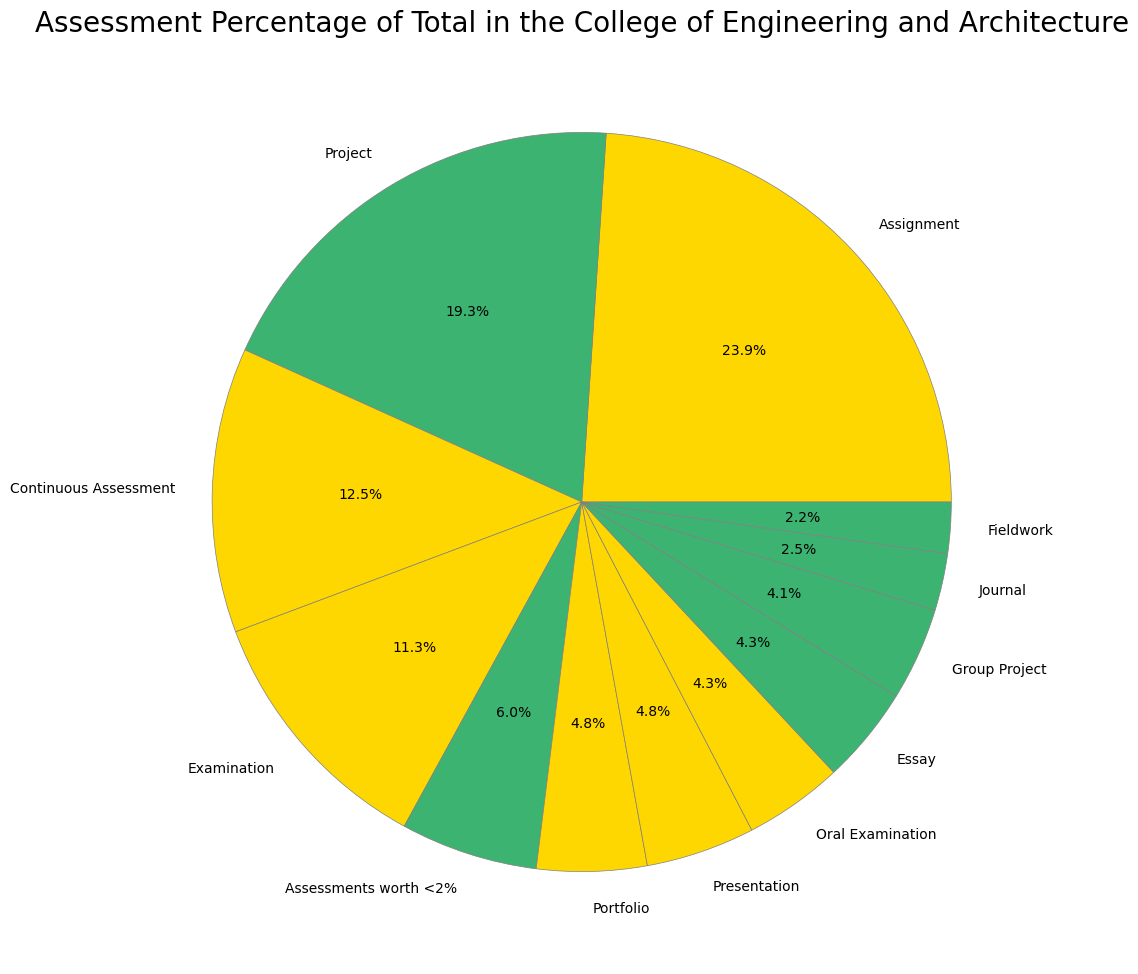

In [8]:
pie_filtered()

Reading from ModuleInformation\_School=Electrical-&-Electronic-Eng
Reading from ModuleInformation\_School=Electrical-&-Electronic-Eng


C:\Users\catha\AppData\Local\Temp\ipykernel_34296\850081594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')


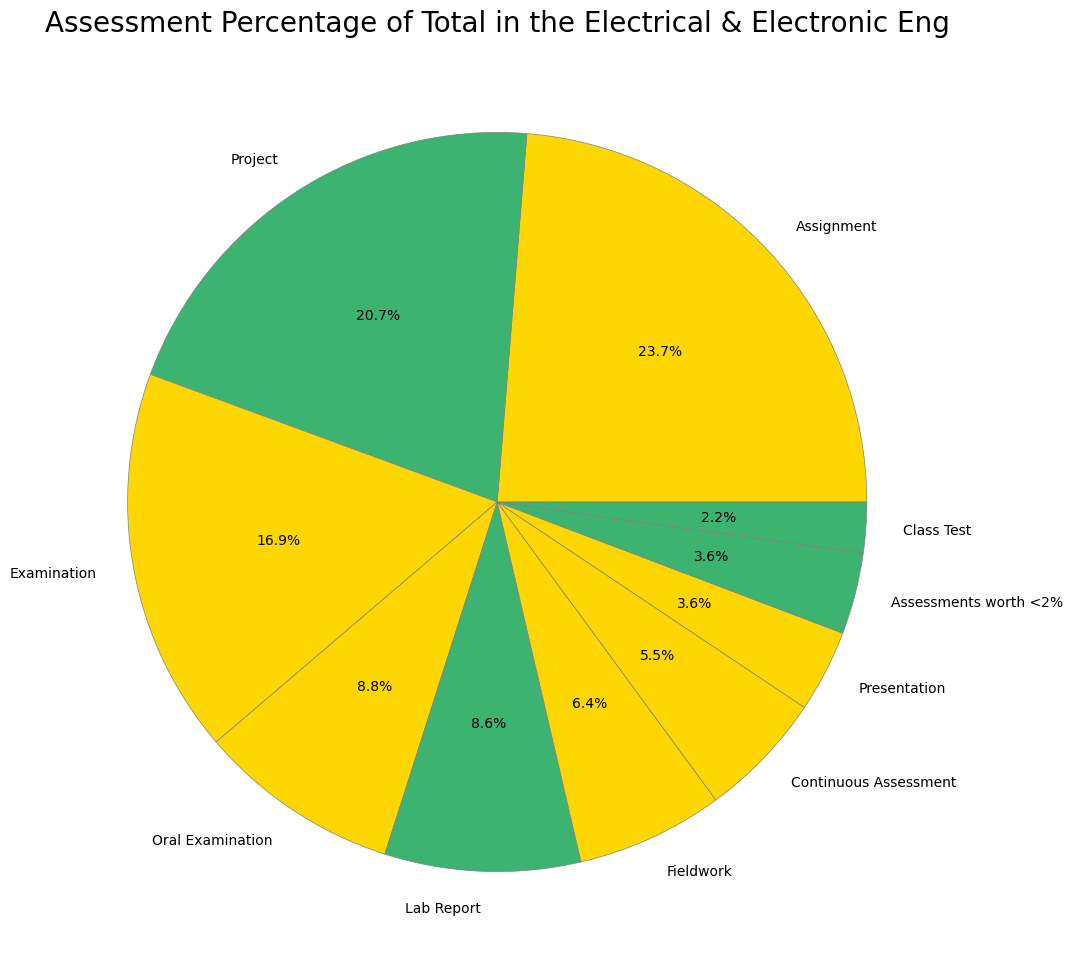

In [9]:
pie_filtered(school="Electrical & Electronic Eng")

Reading from ModuleInformation\_School=Electrical-&-Electronic-Eng
Reading from ModuleInformation\_School=Electrical-&-Electronic-Eng


C:\Users\catha\AppData\Local\Temp\ipykernel_34296\850081594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')


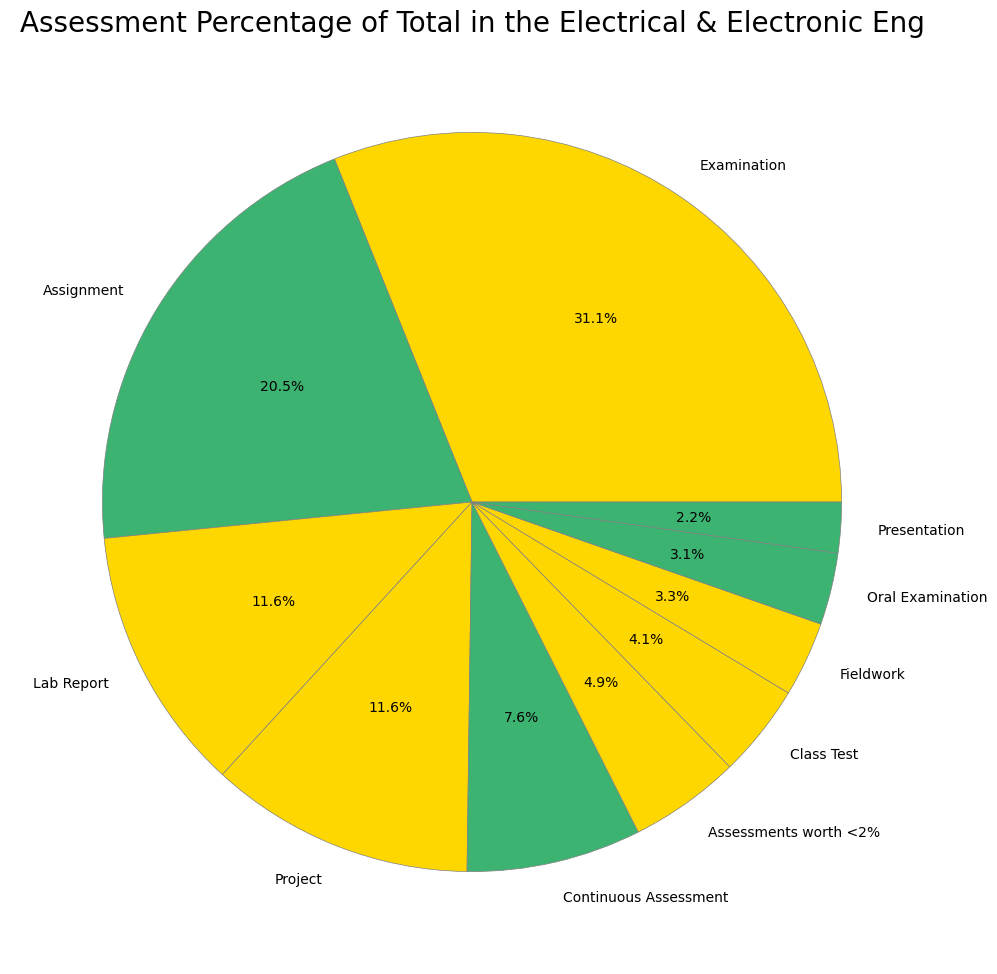

In [10]:
pie_filtered(school="Electrical & Electronic Eng", scaled=False)

Below is a function designed to build charts for a given module set. It identifies which of those modules are using assessment types that are susceptible to ChatGPT and what percentage such assessments are of the overall assessment type. It also publishes below a bar chart that shows the breakdown of assessment types.

In [11]:
#Builds a graph to indicate the susceptibility of a module set's assessments to Chat GPT
def susceptibilty_pie(assessments, scaled=True, school=None, level=None, givenList=None, filename=None, module=None):
    #Data Cleaning and Manipulation Part
    #########################################################################################
    #First we will reduce the assessments dataframe to just the columns we require here.
    assessments=assessments[["Assessment Type", "% of Final Grade", "Scaled % of Final Grade"]]

    #This is the dataset cleaning, so that they are ready for presentation
    assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')
    assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
    assessments=assessments.dropna()
    assessments["Assessment Type"]=assessments["Assessment Type"].astype("category")
    #We will also add in a "Susceptibility" column, based on the python dictionary that can be located above
    assessments["Susceptibility"]=assessments["Assessment Type"].apply(lambda x: susceptibility[x])


    #For the pie chart, group by susceptibilty
    assessment_sus=assessments.groupby(by="Susceptibility").sum()
    #For the bar chart, group by assessment type
    assessment_total=assessments.groupby(by="Assessment Type").sum()

    #Choose whether or not you want to scale by credits, or take all modules to be equal, regardless of credits
    if scaled==True:
        assessment_scale="Scaled % of Final Grade"
    else:
        assessment_scale="% of Final Grade"
        
        
    total=assessment_sus[assessment_scale].sum()

    #Get the percentage each assessment type makes up of the overall for both graphs
    assessment_sus["% of Assessment"]=assessment_sus[assessment_scale].apply(lambda x: x/total)
    assessment_total["% of Assessment"]=assessment_total[assessment_scale].apply(lambda x: x/total)

    #The groupby function removed the categorical "Susceptibility" column. Bring it back
    assessment_total["Susceptiblity"]=assessment_total.index.map(lambda x: susceptibility[x])

    #Sort the totals into descending order, to make it easier to see
    sorted_totals=assessment_total.sort_values(by="% of Assessment", ascending=False)
    #The groupby function removed the categorical "Susceptibility" column. Bring it back
    sorted_totals["Susceptibility"]=sorted_totals.index.map(lambda x: susceptibility[x])

    #Graph building part
    #############################################################################################################
    #Make the figure
    fig, (ax, bx)=plt.subplots(ncols=2, figsize=(16,9))

    #These are for selecting colours and hatching for each pie segment
    colour_dict={"susceptible": "gold", "not susceptible":"lightgrey"}
    hatching_dict={"susceptible": None, "not susceptible":"/"}
    colours=[]
    hatching=[]
    #Get the colours and hatching for each pie segment
    for segment in assessment_sus.index:
        colours.append(colour_dict[segment])
        hatching.append(hatching_dict[segment])
        

    #Make the susceptibility pie chart
    ax.pie(assessment_sus["% of Assessment"], wedgeprops = { 'linewidth' : 0.5, 'edgecolor' : 'white' }, \
           autopct="%1.1f%%", labels=assessment_sus.index, hatch=hatching ,\
           colors=colours, textprops={'fontsize':18})

    #Set the title of the pie chart for ease of understanding
    ax.set_title("Percentage of Assessment Susceptible", fontsize=20)
    
    #These are for selecting colours and hatching for each bar in the bar chart
    colour_dict={"susceptible":"gold", "not susceptible":"lightgrey"}
    hatching_dict={"susceptible": None, "not susceptible":"/"}
    colours=[]
    hatching=[]
    #Get the colours and hatching type based on susceptibilty
    for sus in sorted_totals["Susceptibility"]:
        colours.append(colour_dict[sus])
        hatching.append(hatching_dict[sus])
        
        
    #Make the assessment type breakdown bar chart, with colour and hatching indicating the susceptibility
    bx.barh(sorted_totals.index, sorted_totals["% of Assessment"].apply(lambda x:x*100), edgecolor="white", hatch = hatching ,\
           color=colours)
    
    #Set the options for the axes
    bx.tick_params(axis='y', labelsize=16)
    bx.tick_params(axis='x', rotation=90, labelsize=14)
    #ax.legend(fontsize=20)
    bx.set_xlabel("% of Assessment",fontsize=18)
    #Set the title for the bar chart for ease of understanding
    bx.set_title("Assessment Type Breakdown", fontsize=20)
    

    #Here we want to set the overall title of the charts - to indicate what module subset they are describing
    what="College of Engineering and Architecture"
    if school != None:
        what=""
        what+="School of "
        what+=school
    if level != None:
        what+= " At Level %d" %level
    if filename != None:
        what="".join([(" "+i if i.isupper() else i) for i in filename])
    if module !=None:
        what=module + " Module"
    
    #Set the overall title for the two graphs
    fig.suptitle("Assessment Susceptibilty to ChatGPT in the %s" %what, fontsize=24)
    fig.tight_layout()
    
    #Describe what the figure is
    what=what.replace(" ", "-")
    
    #Set the path to save the graphs
    dir_output=Path.Path("Graphs")
    
    #Set the filename for th figure
    dir_output=dir_output / "Susceptibility"
    dir_output.mkdir(parents=True, exist_ok=True)
    
    filename= dir_output / ("%s.pdf" %what)
    plt.savefig(filename, dpi="figure")

In [12]:
#Builds a graph to indicate the susceptibility of a module set's assessments to Chat GPT
def workType_builder(assessments, scaled=True, school=None, level=None, givenList=None, filename=None, \
                     module=None, time=False, student_credits=False):
    
    num_unique=len(assessments["Module Code"].unique())
    #Data Cleaning and Manipulation Part
    #########################################################################################
    #First we will reduce the assessments dataframe to just the columns we require here.
    #assessments=assessments[["Assessment Type", "% of Final Grade", "Scaled % of Final Grade", "Work Type"]]

    #For the pie chart, group by susceptibilty
    assessment_sus=assessments.groupby(by="Work Type").sum()
    #For the bar chart, group by assessment type
    assessment_total=assessments.groupby(by="Assessment Type").sum()

    #Choose whether or not you want to scale by credits, or take all modules to be equal, regardless of credits
    if student_credits==True:
        assessment_scale="Student Credits"
    elif scaled==True:
        assessment_scale="Scaled % of Final Grade"
    else:
        assessment_scale="% of Final Grade"
        
        
    total=assessment_sus[assessment_scale].sum()

    #Get the percentage each assessment type makes up of the overall for both graphs
    assessment_sus["% of Assessment"]=assessment_sus[assessment_scale].apply(lambda x: x/total)
    assessment_total["% of Assessment"]=assessment_total[assessment_scale].apply(lambda x: x/total)

    #The groupby function removed the categorical "Susceptibility" column. Bring it back
    assessment_total["Work Type"]=assessment_total.index.map(lambda x: work_type[x])

    #Sort the totals into descending order, to make it easier to see
    sorted_totals=assessment_total.sort_values(by="% of Assessment", ascending=False)
    #The groupby function removed the categorical "Susceptibility" column. Bring it back
    sorted_totals["Work Type"]=sorted_totals.index.map(lambda x: work_type[x])

    #Graph building part
    #############################################################################################################
    #Set the font
    plt.rcParams["font.family"] = "sans"
    
    #Make the figure
    fig, (ax, bx)=plt.subplots(ncols=2, figsize=(16, 9))

    #Make a pie chart on the desired axes
    if time == False:
        fig, ax=workType_pie(assessment_sus, fig, ax, num_unique)
    else:
        stage=False
        if filename != None:
            stage=True
        #Make the area level stacked chart
        fig, ax=workType_stackedBar(assessments, fig, ax, scaled=scaled, stage=stage)
        
    #Make the horizontal bar chart on the desired axes
    fig, bx=workType_barh(sorted_totals, fig, bx)
    
    #Here we want to set the overall title of the charts - to indicate what module subset they are describing
    what="College of Engineering and Architecture"
    if school != None:
        what=""
        what+="School of "
        what+=school
    if level != None:
        what+= " At Level %d" %level
    if filename != None:
        what="".join([(" "+i if i.isupper() else i) for i in filename])
    if module != None:
        what = module + " Module"
        
    #Set the overall title for the two graphs
    fig.suptitle("Assessment Breakdown in the %s" %what, fontsize=24)
    fig.tight_layout()
    
    #Describe what the figure is
    what=what.replace(" ", "-")
    
    #Set the path to save the graphs
    dir_output=Path.Path("Graphs")
    
    #Set the filename for th figure
    dir_output=dir_output / "WorkType"
    dir_output.mkdir(parents=True, exist_ok=True)
    
    filename= dir_output / ("%s.pdf" %what)
    plt.savefig(filename, dpi="figure")

This is a function that builds a pie chart as desired, breaking down model assessment by work type.

In [13]:
def workType_pie(assessment_sus, fig, ax, num_unique=None):
        #These are for selecting colours and hatching for each pie segment
    colour_dict={"At home": "#1f78b4", "Hybrid": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Hybrid": None, "In person":None}
    colours=[]
    hatching=[]
    #Get the colours and hatching for each pie segment
    for segment in assessment_sus.index:
        colours.append(colour_dict[segment])
        hatching.append(hatching_dict[segment])

    #Make the susceptibility pie chart
    ax.pie(assessment_sus["% of Assessment"], wedgeprops = { 'linewidth' : 1.5, 'edgecolor' : 'white', "alpha" : 0.9}, \
           autopct="%1.1f%%", labels=assessment_sus.index, hatch=hatching ,\
           colors=colours, textprops={'fontsize':18})

    #Set the title of the pie chart for ease of understanding
    ax.set_title("Proportions of Different Assessment Kinds", fontsize=20)
    
    if num_unique!=None:
        ax.set_xlabel("\n\nNumber of Modules in this Breakdown: %d" %(num_unique), fontsize=20)
    
    return fig, ax

This is a function that creates a horizontal bar chart, break down the assessments by assessment types.

In [14]:
def workType_barh(sorted_totals, fig, bx):
    #These are for selecting colours and hatching for each bar in the bar chart
    colour_dict={"At home": "#1f78b4", "Hybrid": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Hybrid": None, "In person":None}
    colours=[]
    hatching=[]
    #Get the colours and hatching type based on susceptibilty
    for sus in sorted_totals["Work Type"]:
        colours.append(colour_dict[sus])
        hatching.append(hatching_dict[sus])
        
        
    #Make the assessment type breakdown bar chart, with colour and hatching indicating the susceptibility
    bx.barh(sorted_totals.index, sorted_totals["% of Assessment"].apply(lambda x:x*100), edgecolor="white", hatch = hatching ,\
           color=colours, alpha=0.9)
    
    #Set the options for the axes
    bx.tick_params(axis='y', labelsize=16)
    bx.tick_params(axis='x', labelsize=14)
    #ax.legend(fontsize=20)
    bx.set_xlabel("% of Assessment",fontsize=18)
    #Set the title for the bar chart for ease of understanding
    bx.set_title("Assessment Type Breakdown", fontsize=20)
    bx.legend(colours,fontsize=20)
    
    return fig, bx

In [15]:
def workType_levelArea(assessments, fig, ax, scaled=True, stage=False):
    #Choose whether or not you want to scale by credits, or take all modules to be equal, regardless of credits
    if scaled==True:
        assessment_scale="Scaled % of Final Grade"
    else:
        assessment_scale="% of Final Grade"
        
    if stage==False:
        time="Level"
    else:
        time="Stage"
        
    stackedbar=assessments.groupby(by=[time, "Work Type"], as_index=False).sum()

    #These are for selecting colours and hatching for each area segment
    colour_dict={"At home": "#1f78b4", "Hybrid": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Hybrid": None, "In person":None}
    colours=[]
    Stackedwork={}

    
    #Get the colours and hatching for each area segment
    for i, segment in enumerate(stackedbar["Work Type"].unique().tolist()):
        Stackedwork[segment]=stackedbar[stackedbar["Work Type"] == segment][assessment_scale].reset_index(drop=True)
        if i ==0:
            Totalwork=Stackedwork[segment]
        else:
            Totalwork=Totalwork+Stackedwork[segment]
        colours.append(colour_dict[segment])
        #hatching.append(hatching_dict[segment])
    
    ax.stackplot(assessments["Level"].unique().tolist(), Stackedwork["At home"]/Totalwork,  Stackedwork["Hybrid"]/Totalwork, \
                  Stackedwork["In person"]/Totalwork, colors=colours, labels=["At home", "Hybrid", "In person"])
    
        #Set the options for the axes
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    #ax.legend(fontsize=20)
    ax.set_ylabel("Proportion of Assessment",fontsize=18)
    ax.set_xlabel("%s" %time,fontsize=18)
    ax.legend(fontsize=20)
    #Set the title for the bar chart for ease of understanding
    ax.set_title("Assessment Proportions over %s" %time , fontsize=20)
    
    return fig, ax

In [16]:
def workType_stackedBar(assessments, fig, ax, scaled=True, stage=False):
    #Choose whether or not you want to scale by credits, or take all modules to be equal, regardless of credits
    if scaled==True:
        assessment_scale="Scaled % of Final Grade"
    else:
        assessment_scale="% of Final Grade"
        
    if stage==False:
        time="Level"
    else:
        time="Stage"
        
    stackedbar=assessments.groupby(by=["Work Type", time], as_index=False).sum()

    #These are for selecting colours and hatching for each area segment
    colour_dict={"At home": "#1f78b4", "Hybrid": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Hybrid": None, "In person":None}
    colours=[]
    Stackedwork={}

    
    #Get the colours and hatching for each area segment
    for i, segment in enumerate(stackedbar["Work Type"].unique().tolist()):
        Stackedwork[segment]=stackedbar[stackedbar["Work Type"] == segment][assessment_scale].reset_index(drop=True)
        if i ==0:
            Totalwork=Stackedwork[segment]
        else:
            Totalwork=Totalwork+Stackedwork[segment]
        #colours.append(colour_dict[segment])
        #hatching.append(hatching_dict[segment])
    
    ax.bar(assessments["Level"].unique().tolist(), Stackedwork["At home"]/Totalwork*100, color=colour_dict["At home"])
    
    ax.bar(assessments["Level"].unique().tolist(), Stackedwork["Hybrid"]/Totalwork*100, \
           bottom=Stackedwork["At home"]/Totalwork*100, color=colour_dict["Hybrid"])
    
    ax.bar(assessments["Level"].unique().tolist(), Stackedwork["In person"]/Totalwork*100, \
           bottom=Stackedwork["Hybrid"]/Totalwork*100+Stackedwork["At home"]/Totalwork*100, color=colour_dict["In person"])
    #ax.bar(assessments["Level"].unique().tolist(), Stackedwork["At home"]/Totalwork,  Stackedwork["Hybrid"]/Totalwork, \
     #             Stackedwork["In person"]/Totalwork, colors=colours, labels=["At home", "Hybrid", "In person"])
    
        #Set the options for the axes
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    #ax.legend(fontsize=20)
    ax.set_ylabel("Proportion of Assessment",fontsize=18)
    ax.set_xlabel("%s" %time,fontsize=18)
    #ax.legend(["At home", "Hybrid", "In person"],fontsize=20)
    #Set the title for the bar chart for ease of understanding
    ax.set_title("Assessment Proportions over %s" %time , fontsize=20)
    
    return fig, ax

By combining the "susceptibility_pie" function with the "file_finder" function, we have a function that can build graphs immediately after finding the files. This makes it very easy for us going forward. 

In [17]:
#This finds files and then builds graphs based on their content
def susceptibility_graphs(school=None, level=None, givenList=None, scaled=True, filename=None, module=None):
    #Find the desired module subset in the files
    assessments, descriptors = file_finder(school=school, level=level, givenList=givenList, filename=filename, module=module)
    
    #Build a graph describing these module subsets
    susceptibilty_pie(assessments, scaled=scaled, school=school, level=level, givenList=givenList, \
                      filename=filename, module=module)

In [18]:
#This finds files and then builds graphs based on their content
def workType_graphs(school=None, level=None, givenList=None, scaled=True, filename=None, module=None, time=False, \
                   student_credits=False):
    #Find the desired module subset in the files
    assessments, descriptors = file_finder(school=school, level=level, givenList=givenList, filename=filename, module=module)
    
    #Build a graph describing these module subsets
    workType_builder(assessments, scaled=scaled, school=school, level=level,\
                     givenList=givenList, filename=filename, module=module, time=time, student_credits=student_credits)

Now we just need to test the functions.

Reading from ModuleInformation
Reading from ModuleInformation


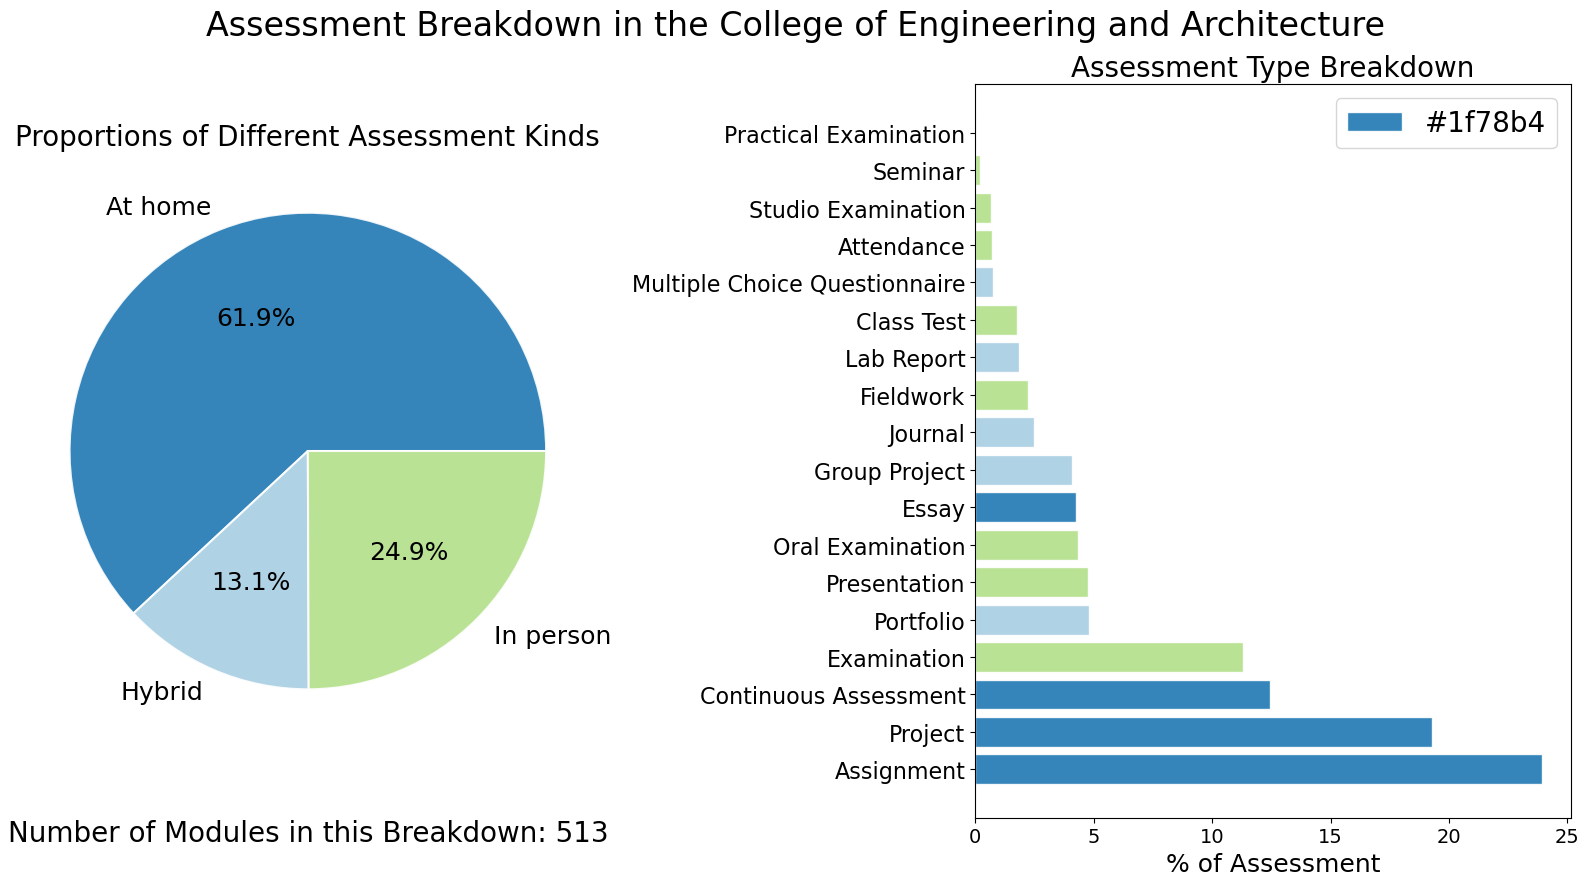

In [19]:
workType_graphs()

Reading from ModuleInformation
Reading from ModuleInformation


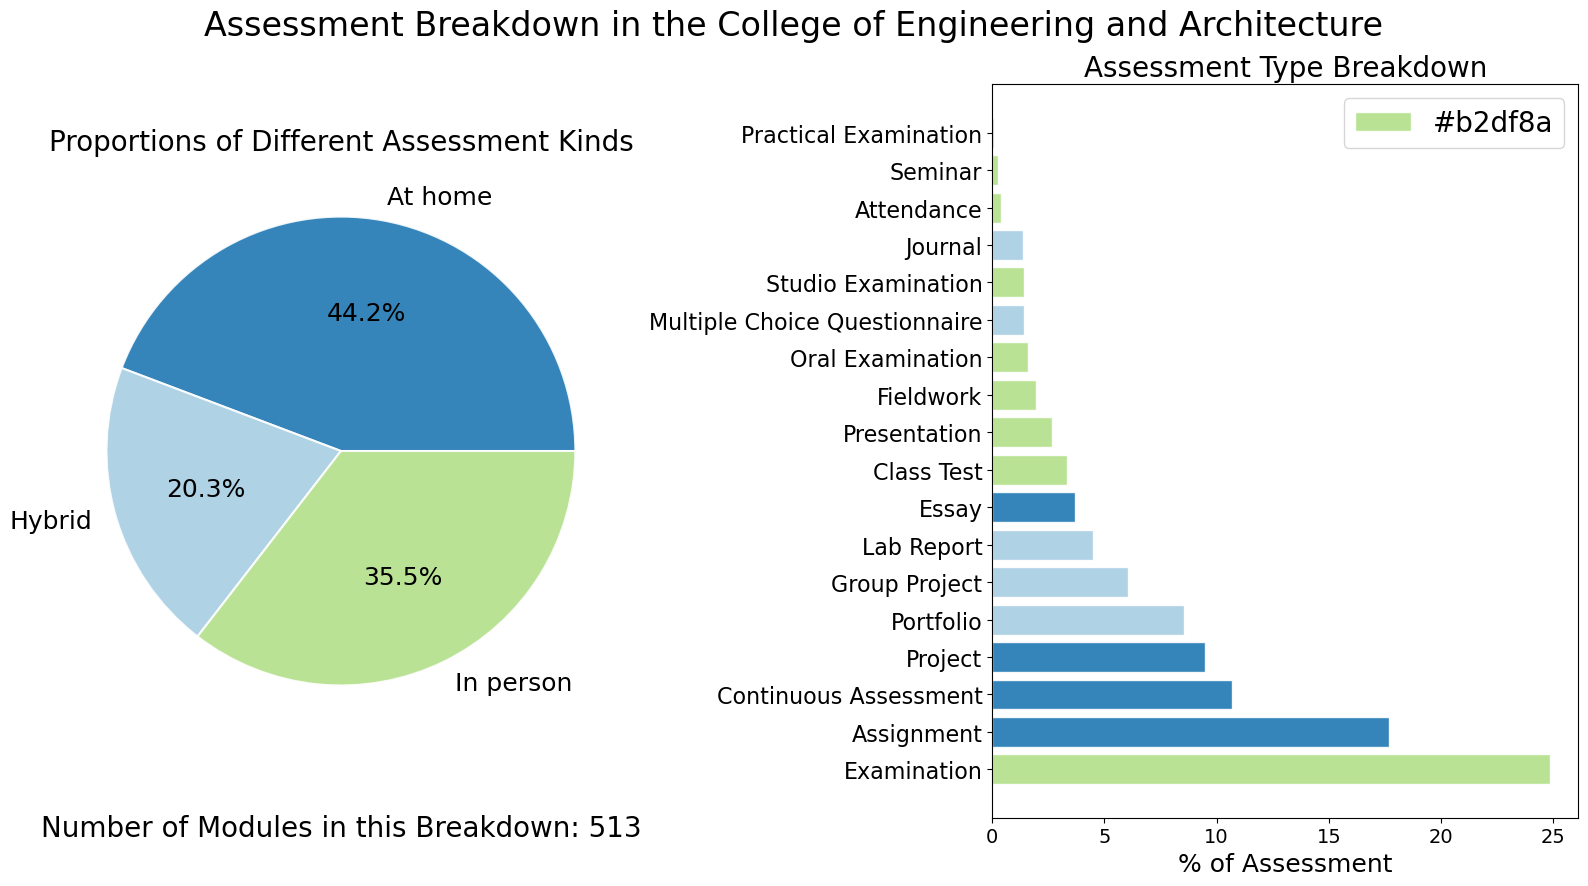

In [20]:
workType_graphs(student_credits=True)

Reading from ModuleInformation
Reading from ModuleInformation


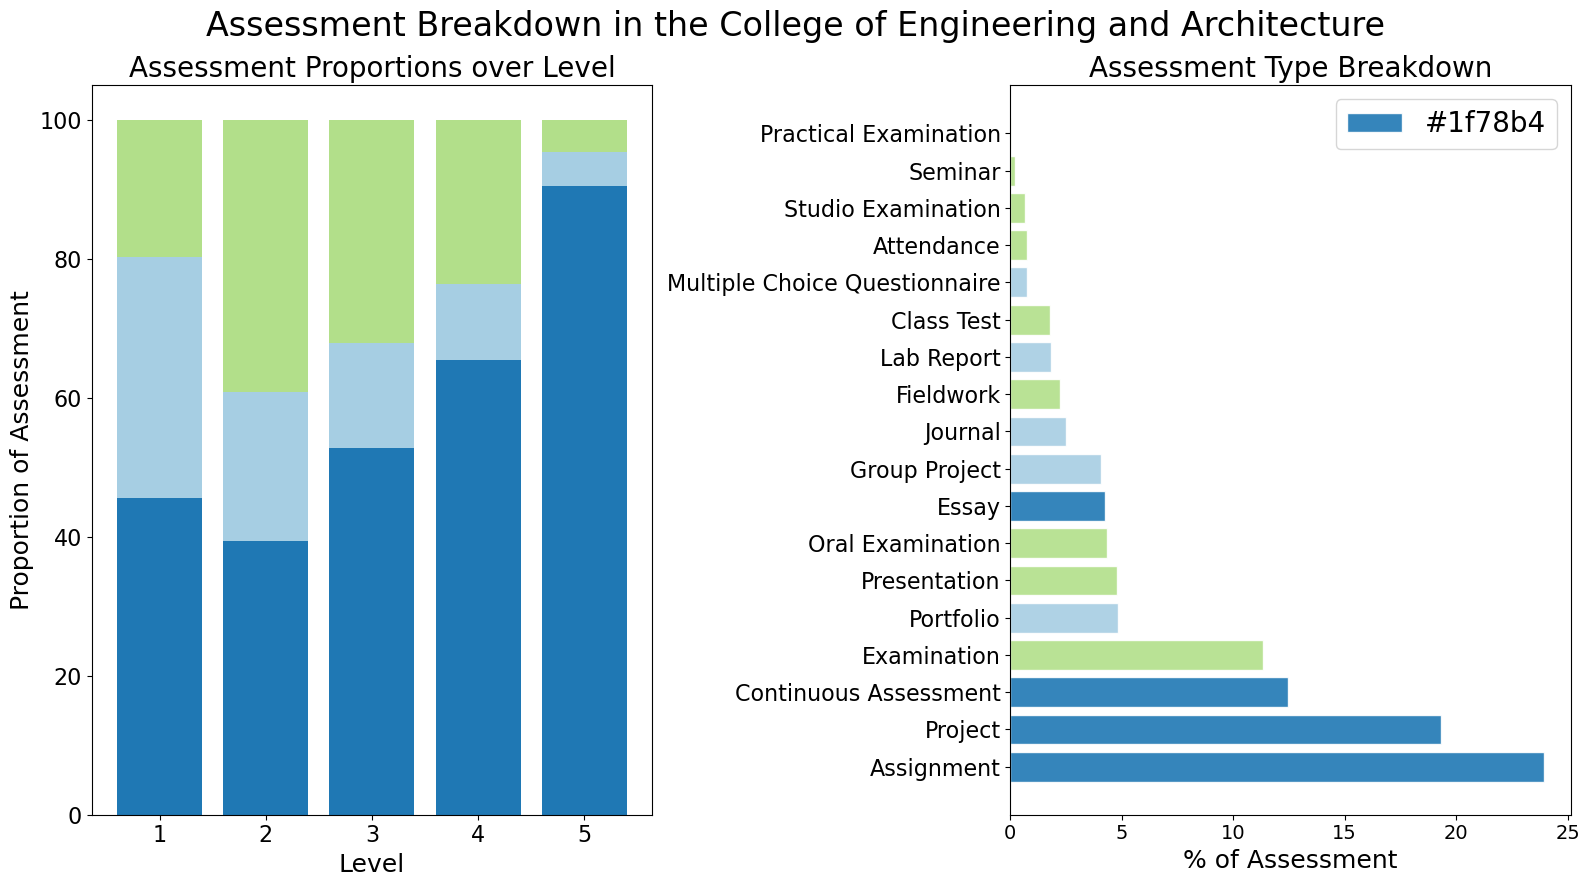

In [21]:
workType_graphs(time=True)

Reading from ModuleInformation\ElectricalPath
Reading from ModuleInformation\ElectricalPath


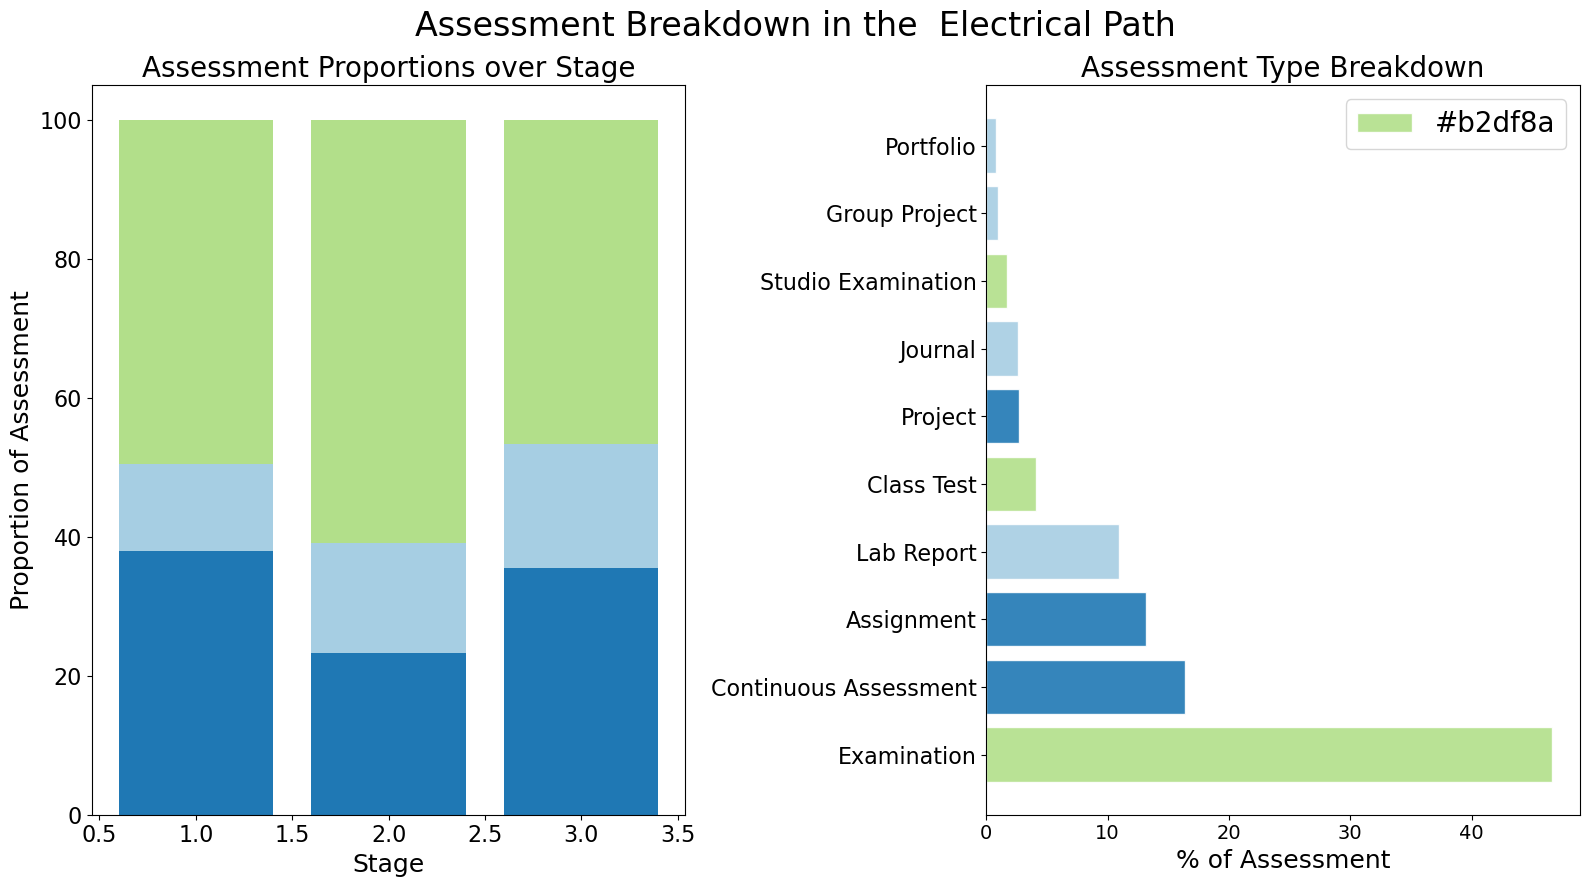

In [22]:
workType_graphs(filename="ElectricalPath", time=True)

Reading from ModuleInformation\ElectricalMastersPath
Reading from ModuleInformation\ElectricalMastersPath


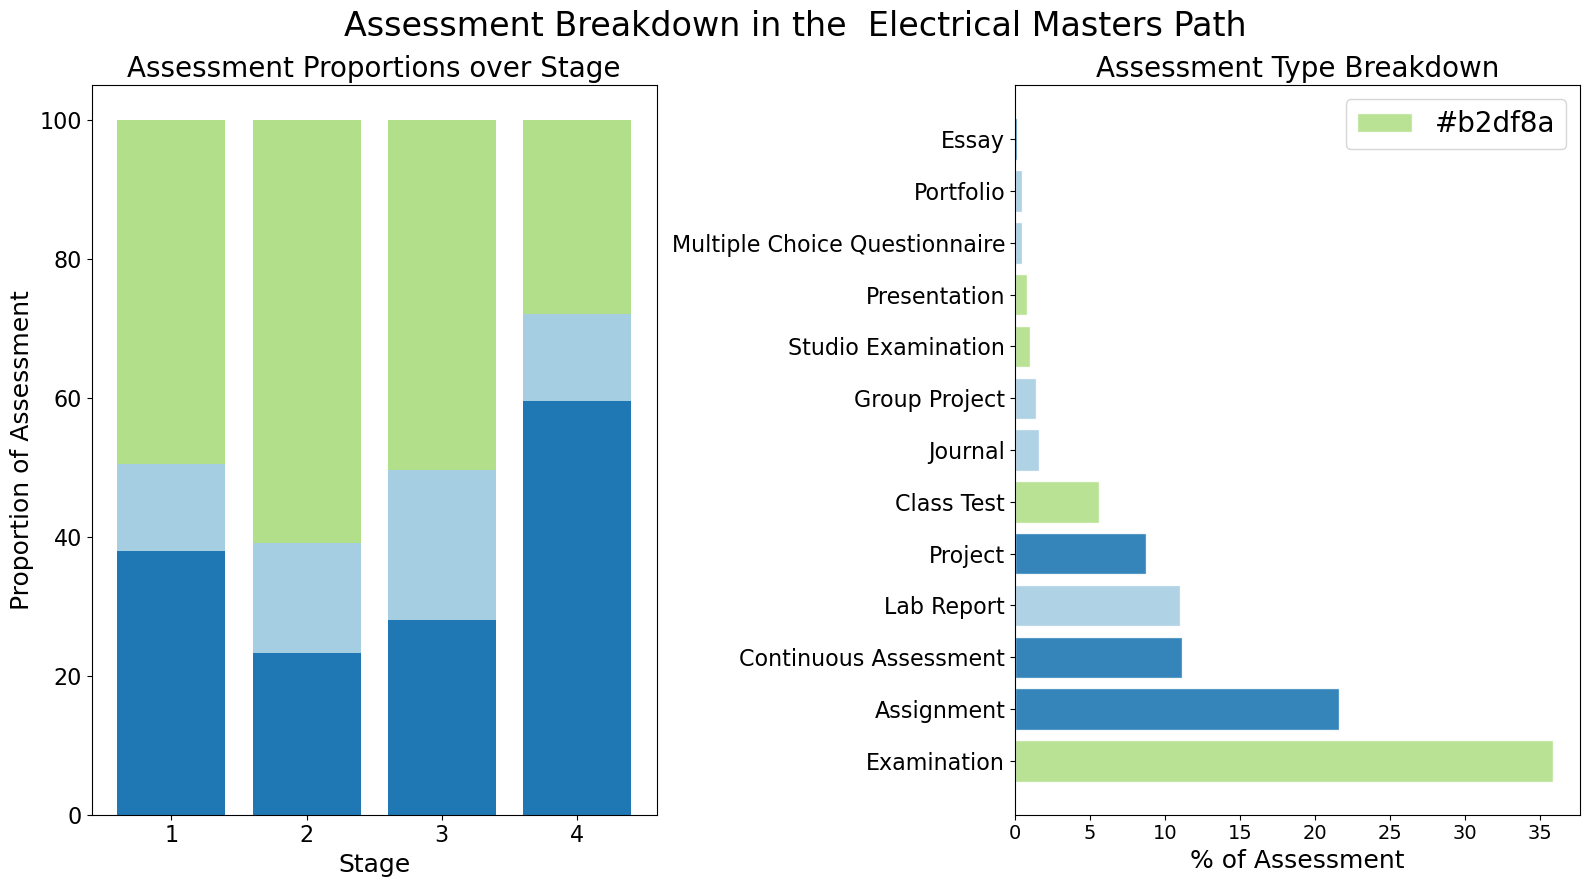

In [23]:
workType_graphs(filename="ElectricalMastersPath", time=True)